In [37]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.sparse.linalg import norm

In [38]:
import sys
sys.path.insert(0, "../scripts")

from SZFW_lasso import *
from DZFW_lasso import *
from IZFW_lasso import *

## Load data: Covtype Dataset

In [39]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [40]:
# space dimension
d = X.shape[1]
n = y.shape[0]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 54
n: 581012


In [41]:
# define the objective function
F = lambda w: 0.5/n * np.sum(np.power(y - X @ w, 2))

In [42]:
# initialize prarameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

# starting point: center
indeces = np.random.randint(low = 0, high = d-1, size = 20)
w0[indeces] = int(0)
w0 = np.zeros(d)
print(f"w0: {w0}")

w0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


## Deterministic Gradient Free Frank Wolfe on Covtype

In [43]:
%%time

# Lipschitz constant 
L = 3

fpred, f, w, mean, t, loss, f_values = detZFW(F, L, d, w0, T=5)

Loss evaluation at time 1:	0.7013836

Loss evaluation at time 2:	0.1212442

Loss evaluation at time 3:	0.0424383

Loss evaluation at time 4:	0.0199207

Loss evaluation at time 5:	0.0109946

CPU times: user 16.5 s, sys: 661 ms, total: 17.1 s
Wall time: 10.2 s


In [44]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.34641199738781203

F(w) = 0.3354173784042209

w = [0.         0.         0.         0.         0.         0.
 0.         0.95238095 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]

average w = [0.         0.         0.         0.         0.         0.
 0.         0.85714286 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

In [45]:
lossd = np.load("../Data/results/loss_dZFW_lasso.npy") # data from colab (NOT NORMALIZED)
f_d = np.load("../Data/results/function_dZFW_lasso.npy")
f_d = f_d/n
f_star = np.min(f_d)
lossd = lossd/n

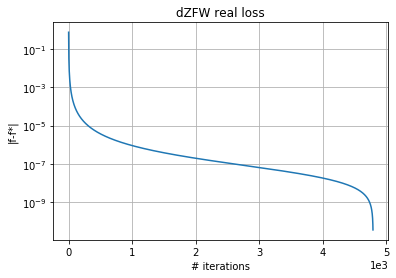

In [46]:
F_evald = np.abs(f_d - f_star)
F_evald = F_evald[:-2]
plt.plot(F_evald)
plt.yscale("log")
plt.title("dZFW real loss")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/dZFW_real_loss", dpi=400)

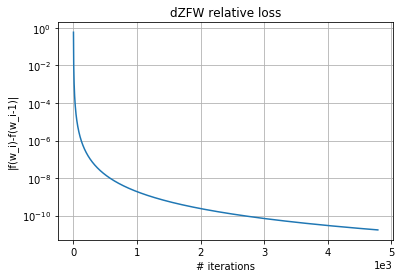

In [47]:
plt.plot(lossd)
plt.yscale("log")
plt.title("dZFW relative loss")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/dZFW_relative_loss", dpi=400)

## Stochastic Gradient Free Frank Wolfe on Covtype

In [48]:
%%time
fpred, f, w, mean, t, loss, f_values = stochasticZFW(F, d, w0, method = "IRDSA1", r=1, T=10, eps=1e-10)

Loss evaluation at time 1:	0.0275749

Loss evaluation at time 2:	0.0056888

Loss evaluation at time 3:	0.2195518

Loss evaluation at time 4:	0.0789956

Loss evaluation at time 5:	0.0358417

Loss evaluation at time 6:	0.1041304

Loss evaluation at time 7:	0.0282238

Loss evaluation at time 8:	0.0458985

Loss evaluation at time 9:	0.0664736

Loss evaluation at time 10:	0.0526058

CPU times: user 4.87 s, sys: 287 ms, total: 5.15 s
Wall time: 3.55 s


In [49]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.722194251100365

F(w) = 0.6695884777393749

w = [ 0.16339869  0.07843137  0.          0.          0.          0.
  0.21568627  0.1503268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.09803922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.05228758  0.          0.          0.         -0.05882353  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]

average w = [ 0.12222222  0.06666667  0.          0.          0.          0.
  0.03333333  0.14444444  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03333333
  0.          0.  

In [50]:
loss_stochm6 = np.load("../Data/results/loss_SZFWm6_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm6 = np.load("../Data/results/function_SZFWm6_lasso.npy")
f_stochm6 = f_stochm6/n

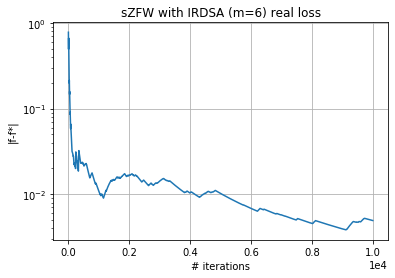

In [51]:
F_evalsm6 = np.abs(f_stochm6 - f_star)
plt.plot(F_evalsm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6) real loss")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/sZFW_IRDSAm6_real_loss", dpi=400)

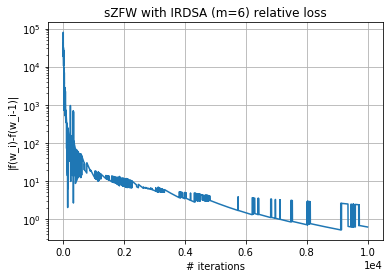

In [52]:
plt.plot(loss_stochm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6) relative loss")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/sZFW_IRDSAm6_relative_loss", dpi=400)

In [53]:
loss_stochm1 = np.load("../Data/results/loss_SZFWm1_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm1 = np.load("../Data/results/function_SZFWm1_lasso.npy")
f_stochm1 = f_stochm1/n

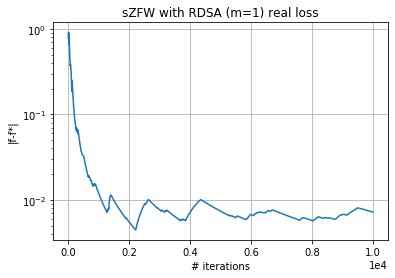

In [54]:
F_evalsm1 = np.abs(f_stochm1 - f_star)
plt.plot(F_evalsm1)
plt.yscale("log")
plt.title("sZFW with RDSA (m=1) real loss")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f-f*|")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/sZFW_IRDSAm1_real_loss", dpi=400)

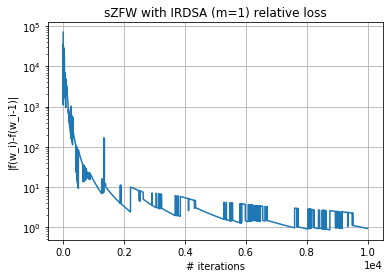

In [55]:
plt.plot(loss_stochm1)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=1) relative loss")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/sZFW_IRDSAm1_relative_loss", dpi=400)

## Zeroth order stochastic accelerated gradient method with Inexact updates on Covtype

In [56]:
# setting parameters
L = 3
D = 20 # we will start from m = 6, up to T * (T+1) / D * (d+3) = 28785 (for T=100) m> d
#D = 10000 # m < d
B = 1

In [57]:
%%time 

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 2, eps = 1e-8)

Loss evaluation at time 1:	0.2841402

Loss evaluation at time 2:	0.2480290

Loss evaluation at time 3:	0.1184176

Loss evaluation at time 4:	0.0764265

Loss evaluation at time 5:	0.0481458

Loss evaluation at time 6:	0.0332311

Loss evaluation at time 7:	0.0241445

Loss evaluation at time 8:	0.0164301

Loss evaluation at time 9:	0.0117840

Loss evaluation at time 10:	0.0086561



KeyboardInterrupt: 

In [22]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 0.722194251100365

F(w) = 0.6695884777393749

w = [ 0.16339869  0.07843137  0.          0.          0.          0.
  0.21568627  0.1503268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.09803922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.05228758  0.          0.          0.         -0.05882353  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]

average w = [ 0.12222222  0.06666667  0.          0.          0.          0.
  0.03333333  0.14444444  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03333333
  0.          0.          0.          0.      

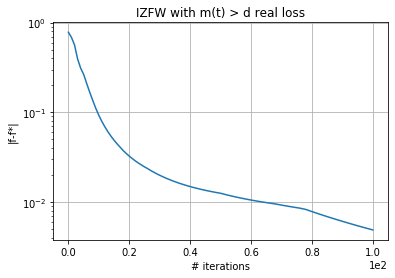

In [64]:
f_inex = np.load('../Data/results/function_IZFW_lasso_long.npy') # data from cluster
loss_inex = np.load('../Data/results/loss_IZFW_lasso_long.npy')
inner_inex = np.load('../Data/results/inner_IZFW_lasso_long.npy')
F_eval_inex = np.abs(f_inex - f_star)
plt.plot(F_eval_inex)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) > d real loss")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/IZFW_IRDSA_real_loss", dpi=400)

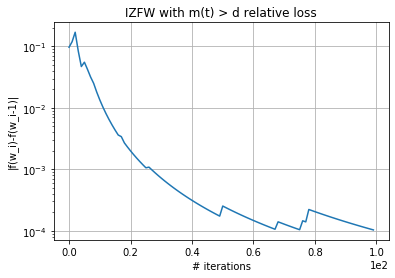

In [65]:
plt.plot(loss_inex)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) > d relative loss")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/IZFW_IRDSA_relative_loss", dpi=400)

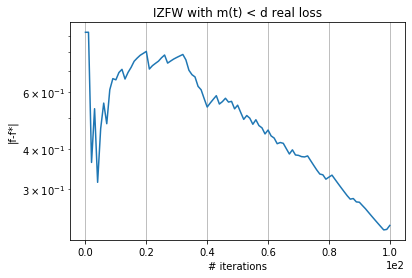

In [66]:
f_inex_mind = np.load('../Data/results/function_IZFW_lasso_mind.npy') # data from cluster
loss_inex_mind = np.load('../Data/results/loss_IZFW_lasso_mind.npy')
inner_inex_mind = np.load('../Data/results/inner_IZFW_lasso_mind.npy')
F_eval_inex_mind = np.abs(f_inex_mind - f_star)
plt.plot(F_eval_inex_mind)
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) < d real loss")
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/IZFW_IRDSA_mind_real_loss", dpi=400)

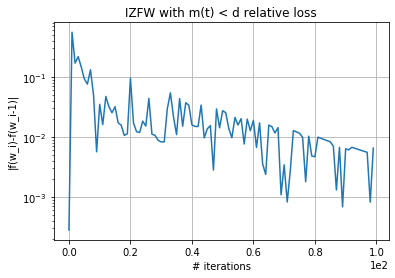

In [67]:
plt.plot(loss_inex_mind)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) < d relative loss")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/IZFW_IRDSA_mind_relative_loss", dpi=400)

## Result Comparison on Covtype


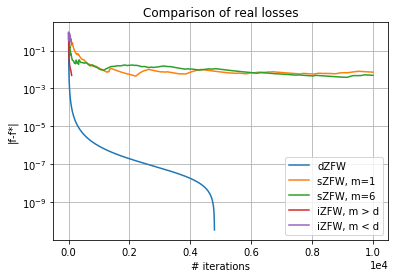

In [68]:
plt.plot(F_evald)
plt.plot(F_evalsm1)
plt.plot(F_evalsm6)
plt.plot(F_eval_inex)
plt.plot(F_eval_inex_mind)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, m > d", "iZFW, m < d"))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/Comparison_real_losses_iteration", dpi=400)

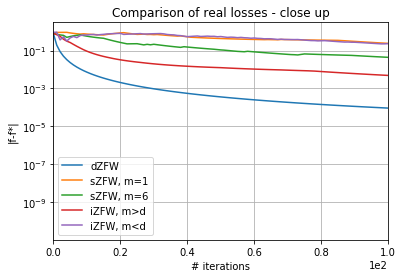

In [69]:
plt.plot(F_evald)
plt.plot(F_evalsm1)
plt.plot(F_evalsm6)
plt.plot(F_eval_inex)
plt.plot(F_eval_inex_mind)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.xlim((0, 100))
plt.title("Comparison of real losses - close up")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, m>d", "iZFW, m<d"))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/Comparison_real_losses_iteration_closeup", dpi=400)

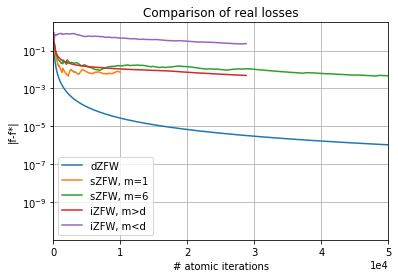

In [70]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, len(F_evald)*d, d), F_evald)
plt.plot(range(0, len(F_evalsm1)*1, 1), F_evalsm1)
plt.plot(range(0, len(F_evalsm6)*6, 6), F_evalsm6)
plt.plot([m(t)+inner_inex[t] for t in range(101)], F_eval_inex)
plt.plot([m(t)+inner_inex_mind[t] for t in range(101)], F_eval_inex_mind)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, m>d", "iZFW, m<d"))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.xlim((0,50000))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/Comparison_real_losses_atomic", dpi=400)

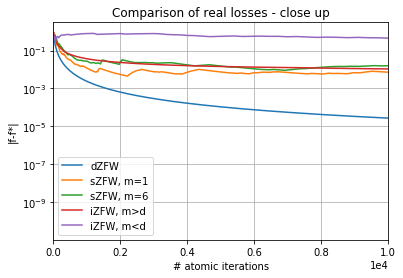

In [73]:
plt.plot(range(1, len(F_evald)*d, d), F_evald)
plt.plot(range(0, len(F_evalsm1)*1, 1), F_evalsm1)
plt.plot(range(0, len(F_evalsm6)*6, 6), F_evalsm6)
plt.plot([np.ceil(m(t))+inner_inex[t] for t in range(101)], F_eval_inex)
plt.plot([np.ceil(m(t))+inner_inex_mind[t] for t in range(101)], F_eval_inex_mind)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, m>d", "iZFW, m<d"))
plt.yscale("log")
plt.title("Comparison of real losses - close up")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.xlim((0,10000))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/Comparison_real_losses_atomic_closeup", dpi=400)

In [74]:
inner_inex

array([ 0, 17, 21, 21, 14, 12,  7, 12,  7, 10,  1,  1,  1,  1,  1,  1,  1,
        1,  4,  5,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  5,  1,  1,  1,  1,  1,  1,  1,  6,  1,  2,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [75]:
inner_inex_mind


array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2])

# Load data: artificial dataset


In [86]:
def CreateDataSet(n, d, s):
    """
    n rows, d features, s sparsity level
    """
    np.random.seed(1007)
    s = np.int(d * s)
    X = np.random.randn(n,d) 
    pn = int(s/2)
    w_s = np.concatenate((np.ones(pn), -np.ones(pn), np.zeros(d-2*pn)))
    w_s = w_s/np.sum(np.abs(w_s))
    epsilon = 0.01*np.random.rand(n) # noise
    y = X @ w_s + epsilon
    return X, y, w_s, epsilon

In [87]:
X, y, w_star, noise = CreateDataSet(n = 100, d = 1000, s = 0.05)

In [88]:
np.sum(np.abs(w_star))

1.0

In [89]:
# space dimension
d = X.shape[1]
n = y.shape[0]
f_star = F(w_star)
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")
print(f"f* = {f_star:.8f}")

Space Dimensions
d: 1000
n: 100
f* = 0.00001625


In [90]:
# initialize parameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

# starting point: center
indeces = np.random.randint(low = 0, high = d-1, size = int(d/2))
w0[indeces] = int(0)
print(f"w0: {w0[:10]}, {np.count_nonzero(w0)} elements different from zero")

w0: [0.00000000e+00 6.94725184e-05 5.32349094e-07 6.23650766e-05
 0.00000000e+00 2.30543109e-05 0.00000000e+00 4.58801767e-05
 6.46670184e-05 0.00000000e+00], 595 elements different from zero


## Deterministic Gradient Free Frank Wolfe on Artificial Dataset

In [91]:
# Lipshitz constant 
L = 2/X.shape[0] * np.linalg.norm(X.T @ X)
print(L)

208.62395959442188


In [93]:
%%time

# Lipschitz constant 

fpred, f, w, mean, t, loss, f_valuesd = detZFW(F, L, d, w0, T=1000, eps = 1e-8)

Loss evaluation at time 1:	0.2869688

Loss evaluation at time 2:	0.2624069

Loss evaluation at time 3:	0.0283229

Loss evaluation at time 4:	0.0363124

Loss evaluation at time 5:	0.0025483

Loss evaluation at time 6:	0.0077457

Loss evaluation at time 7:	0.0023958

Loss evaluation at time 8:	0.0006643

Loss evaluation at time 9:	0.0035124

Loss evaluation at time 10:	0.0015967

Loss evaluation at time 11:	0.0036494

Loss evaluation at time 12:	0.0023726

Loss evaluation at time 13:	0.0035014

Loss evaluation at time 14:	0.0010940

Loss evaluation at time 15:	0.0018221

Loss evaluation at time 16:	0.0000485

Loss evaluation at time 17:	0.0014287

Loss evaluation at time 18:	0.0023645

Loss evaluation at time 19:	0.0007307

Loss evaluation at time 20:	0.0011386

Loss evaluation at time 21:	0.0002368

Loss evaluation at time 22:	0.0005389

Loss evaluation at time 23:	0.0001284

Loss evaluation at time 24:	0.0002807

Loss evaluation at time 25:	0.0003878

Loss evaluation at time 26:	0.0004

Loss evaluation at time 209:	0.0000076

Loss evaluation at time 210:	0.0000016

Loss evaluation at time 211:	0.0000036

Loss evaluation at time 212:	0.0000067

Loss evaluation at time 213:	0.0000238

Loss evaluation at time 214:	0.0000040

Loss evaluation at time 215:	0.0000133

Loss evaluation at time 216:	0.0000115

Loss evaluation at time 217:	0.0000009

Loss evaluation at time 218:	0.0000012

Loss evaluation at time 219:	0.0000008

Loss evaluation at time 220:	0.0000127

Loss evaluation at time 221:	0.0000132

Loss evaluation at time 222:	0.0000017

Loss evaluation at time 223:	0.0000057

Loss evaluation at time 224:	0.0000051

Loss evaluation at time 225:	0.0000016

Loss evaluation at time 226:	0.0000001

Loss evaluation at time 227:	0.0000018

Loss evaluation at time 228:	0.0000019

Loss evaluation at time 229:	0.0000194

Loss evaluation at time 230:	0.0000032

Loss evaluation at time 231:	0.0000079

Loss evaluation at time 232:	0.0000040

Loss evaluation at time 233:	0.0000155



In [94]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376756

F(w_pred) = 0.00015722185392171386

F(w) = 0.00015722510307105127

w = [ 0.00000000e+00  2.19669002e-09  1.68326407e-11  1.97195588e-09
  0.00000000e+00  6.60848742e-03  0.00000000e+00  1.45071070e-09
  3.69948981e-03  0.00000000e+00  0.00000000e+00  4.74515930e-10
  7.92202773e-10  1.42048216e-09  2.24498830e-03  2.63663869e-09
  2.16029669e-09  0.00000000e+00  0.00000000e+00  9.68511210e-10
  0.00000000e+00  7.27249923e-03  0.00000000e+00  2.29969919e-10
  2.68046521e-09  2.71493511e-09  1.97556516e-09  4.74539905e-10
 -2.08688928e-03 -5.47018276e-03  0.00000000e+00 -2.44419149e-02
  0.00000000e+00  1.36442998e-09 -4.64807437e-03  0.00000000e+00
 -2.40624782e-02  2.54195325e-10  1.46595254e-09 -4.90103080e-03
  0.00000000e+00  2.70281978e-09 -3.41491178e-03  6.71313771e-10
 -6.98792133e-03  0.00000000e+00 -1.07190286e-02  2.33145447e-09
  1.47518269e-09  1.43269332e-10  0.00000000e+00 -7.11439890e-03
  0.00000000e+00  2.30688825e-09  2.00583715e

In [100]:
loss_ad = np.load("../Data/results/loss_dZFW_lasso_AD.npy")
f_valuesd = np.load("../Data/results/function_dZFW_lasso_AD.npy")

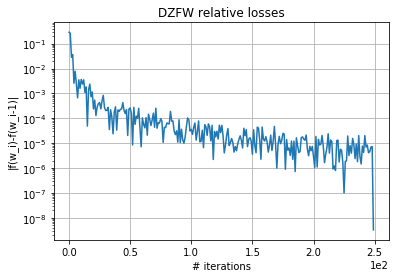

In [101]:
plt.plot(loss_ad)
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title("DZFW relative losses")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/dZFW_relative_loss", dpi=400)

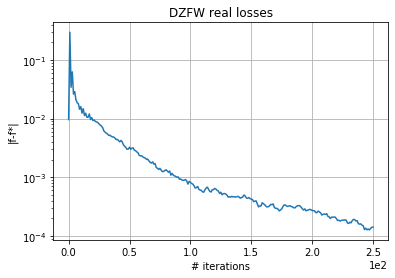

In [102]:
plt.plot(np.abs(f_valuesd - f_star))
plt.yscale("log")
plt.title("DZFW real losses")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/dZFW_real_loss", dpi=400)

## Stochastic Gradient Free Frank Wolfe on Artificial Dataset

In [103]:
%%time
fpred, f, w, mean, t, lossm1ad, f_valuessm1ad = stochasticZFW(F, d, w0, method = "RDSA", r=1, T=10000, eps=1e-8)

Loss evaluation at time 1:	0.0251493

Loss evaluation at time 2:	0.0103963

Loss evaluation at time 3:	0.0084094

Loss evaluation at time 4:	0.0316299

Loss evaluation at time 5:	0.0128758

Loss evaluation at time 6:	0.0335173

Loss evaluation at time 7:	0.0196860

Loss evaluation at time 8:	0.0120568

Loss evaluation at time 9:	0.0023602

Loss evaluation at time 10:	0.0104461

Loss evaluation at time 11:	0.0031741

Loss evaluation at time 12:	0.0137573

Loss evaluation at time 13:	0.0024111

Loss evaluation at time 14:	0.0076494

Loss evaluation at time 15:	0.0087941

Loss evaluation at time 16:	0.0027370

Loss evaluation at time 17:	0.0011948

Loss evaluation at time 18:	0.0068289

Loss evaluation at time 19:	0.0051005

Loss evaluation at time 20:	0.0005636

Loss evaluation at time 21:	0.0026952

Loss evaluation at time 22:	0.0050128

Loss evaluation at time 23:	0.0010362

Loss evaluation at time 24:	0.0025756

Loss evaluation at time 25:	0.0052413

Loss evaluation at time 26:	0.0071


Loss evaluation at time 255:	0.0003279

Loss evaluation at time 256:	0.0003846

Loss evaluation at time 257:	0.0003194

Loss evaluation at time 258:	0.0004987

Loss evaluation at time 259:	0.0004290

Loss evaluation at time 260:	0.0004876

Loss evaluation at time 261:	0.0004240

Loss evaluation at time 262:	0.0003624

Loss evaluation at time 263:	0.0007716

Loss evaluation at time 264:	0.0004667

Loss evaluation at time 265:	0.0004151

Loss evaluation at time 266:	0.0003650

Loss evaluation at time 267:	0.0003165

Loss evaluation at time 268:	0.0002695

Loss evaluation at time 269:	0.0002239

Loss evaluation at time 270:	0.0001798

Loss evaluation at time 271:	0.0001371

Loss evaluation at time 272:	0.0000956

Loss evaluation at time 273:	0.0000555

Loss evaluation at time 274:	0.0003828

Loss evaluation at time 275:	0.0003347

Loss evaluation at time 276:	0.0000490

Loss evaluation at time 277:	0.0000141

Loss evaluation at time 278:	0.0006379

Loss evaluation at time 279:	0.0005847


Loss evaluation at time 479:	0.0002944

Loss evaluation at time 480:	0.0003037

Loss evaluation at time 481:	0.0003128

Loss evaluation at time 482:	0.0003216

Loss evaluation at time 483:	0.0003304

Loss evaluation at time 484:	0.0003389

Loss evaluation at time 485:	0.0003472

Loss evaluation at time 486:	0.0003554

Loss evaluation at time 487:	0.0003634

Loss evaluation at time 488:	0.0003713

Loss evaluation at time 489:	0.0003008

Loss evaluation at time 490:	0.0002846

Loss evaluation at time 491:	0.0002687

Loss evaluation at time 492:	0.0002531

Loss evaluation at time 493:	0.0002377

Loss evaluation at time 494:	0.0002226

Loss evaluation at time 495:	0.0002077

Loss evaluation at time 496:	0.0001931

Loss evaluation at time 497:	0.0004194

Loss evaluation at time 498:	0.0003991

Loss evaluation at time 499:	0.0001726

Loss evaluation at time 500:	0.0002804

Loss evaluation at time 501:	0.0002626

Loss evaluation at time 502:	0.0002451

Loss evaluation at time 503:	0.0002278




Loss evaluation at time 757:	0.0000081

Loss evaluation at time 758:	0.0000921

Loss evaluation at time 759:	0.0000850

Loss evaluation at time 760:	0.0000781

Loss evaluation at time 761:	0.0000712

Loss evaluation at time 762:	0.0000644

Loss evaluation at time 763:	0.0000577

Loss evaluation at time 764:	0.0000510

Loss evaluation at time 765:	0.0000445

Loss evaluation at time 766:	0.0001947

Loss evaluation at time 767:	0.0000702

Loss evaluation at time 768:	0.0001222

Loss evaluation at time 769:	0.0001153

Loss evaluation at time 770:	0.0001086

Loss evaluation at time 771:	0.0001019

Loss evaluation at time 772:	0.0000953

Loss evaluation at time 773:	0.0000888

Loss evaluation at time 774:	0.0000823

Loss evaluation at time 775:	0.0000759

Loss evaluation at time 776:	0.0000696

Loss evaluation at time 777:	0.0000634

Loss evaluation at time 778:	0.0000572

Loss evaluation at time 779:	0.0000511

Loss evaluation at time 780:	0.0000451

Loss evaluation at time 781:	0.0000391


Loss evaluation at time 1022:	0.0000099

Loss evaluation at time 1023:	0.0000067

Loss evaluation at time 1024:	0.0000035

Loss evaluation at time 1025:	0.0000003

Loss evaluation at time 1026:	0.0000028

Loss evaluation at time 1027:	0.0000059

Loss evaluation at time 1028:	0.0000090

Loss evaluation at time 1029:	0.0000120

Loss evaluation at time 1030:	0.0000151

Loss evaluation at time 1031:	0.0000181

Loss evaluation at time 1032:	0.0000210

Loss evaluation at time 1033:	0.0000240

Loss evaluation at time 1034:	0.0000269

Loss evaluation at time 1035:	0.0000298

Loss evaluation at time 1036:	0.0000327

Loss evaluation at time 1037:	0.0000355

Loss evaluation at time 1038:	0.0000383

Loss evaluation at time 1039:	0.0000411

Loss evaluation at time 1040:	0.0000439

Loss evaluation at time 1041:	0.0000466

Loss evaluation at time 1042:	0.0000493

Loss evaluation at time 1043:	0.0000520

Loss evaluation at time 1044:	0.0000547

Loss evaluation at time 1045:	0.0000574

Loss evaluation 

Loss evaluation at time 1261:	0.0000190

Loss evaluation at time 1262:	0.0000215

Loss evaluation at time 1263:	0.0000239

Loss evaluation at time 1264:	0.0000264

Loss evaluation at time 1265:	0.0000288

Loss evaluation at time 1266:	0.0000312

Loss evaluation at time 1267:	0.0000337

Loss evaluation at time 1268:	0.0000360

Loss evaluation at time 1269:	0.0000384

Loss evaluation at time 1270:	0.0000408

Loss evaluation at time 1271:	0.0000431

Loss evaluation at time 1272:	0.0000454

Loss evaluation at time 1273:	0.0000504

Loss evaluation at time 1274:	0.0000471

Loss evaluation at time 1275:	0.0000438

Loss evaluation at time 1276:	0.0000405

Loss evaluation at time 1277:	0.0000372

Loss evaluation at time 1278:	0.0000340

Loss evaluation at time 1279:	0.0000308

Loss evaluation at time 1280:	0.0000276

Loss evaluation at time 1281:	0.0000244

Loss evaluation at time 1282:	0.0000212

Loss evaluation at time 1283:	0.0000150

Loss evaluation at time 1284:	0.0000175

Loss evaluation 


Loss evaluation at time 1503:	0.0000091

Loss evaluation at time 1504:	0.0000076

Loss evaluation at time 1505:	0.0000061

Loss evaluation at time 1506:	0.0000046

Loss evaluation at time 1507:	0.0000031

Loss evaluation at time 1508:	0.0000016

Loss evaluation at time 1509:	0.0000001

Loss evaluation at time 1510:	0.0000014

Loss evaluation at time 1511:	0.0000028

Loss evaluation at time 1512:	0.0000043

Loss evaluation at time 1513:	0.0000057

Loss evaluation at time 1514:	0.0000071

Loss evaluation at time 1515:	0.0000086

Loss evaluation at time 1516:	0.0000100

Loss evaluation at time 1517:	0.0000114

Loss evaluation at time 1518:	0.0000128

Loss evaluation at time 1519:	0.0000142

Loss evaluation at time 1520:	0.0000156

Loss evaluation at time 1521:	0.0000169

Loss evaluation at time 1522:	0.0000183

Loss evaluation at time 1523:	0.0000197

Loss evaluation at time 1524:	0.0000210

Loss evaluation at time 1525:	0.0000224

Loss evaluation at time 1526:	0.0000237

Loss evaluation

Loss evaluation at time 1797:	0.0000254

Loss evaluation at time 1798:	0.0000240

Loss evaluation at time 1799:	0.0000226

Loss evaluation at time 1800:	0.0000213

Loss evaluation at time 1801:	0.0000200

Loss evaluation at time 1802:	0.0000186

Loss evaluation at time 1803:	0.0000173

Loss evaluation at time 1804:	0.0000160

Loss evaluation at time 1805:	0.0000146

Loss evaluation at time 1806:	0.0000133

Loss evaluation at time 1807:	0.0000120

Loss evaluation at time 1808:	0.0000107

Loss evaluation at time 1809:	0.0000095

Loss evaluation at time 1810:	0.0000082

Loss evaluation at time 1811:	0.0000069

Loss evaluation at time 1812:	0.0000056

Loss evaluation at time 1813:	0.0000044

Loss evaluation at time 1814:	0.0000031

Loss evaluation at time 1815:	0.0000018

Loss evaluation at time 1816:	0.0000006

Loss evaluation at time 1817:	0.0000006

Loss evaluation at time 1818:	0.0000019

Loss evaluation at time 1819:	0.0000031

Loss evaluation at time 1820:	0.0000043

Loss evaluation 

Loss evaluation at time 2091:	0.0000362

Loss evaluation at time 2092:	0.0000352

Loss evaluation at time 2093:	0.0000343

Loss evaluation at time 2094:	0.0000334

Loss evaluation at time 2095:	0.0000325

Loss evaluation at time 2096:	0.0000315

Loss evaluation at time 2097:	0.0000306

Loss evaluation at time 2098:	0.0000297

Loss evaluation at time 2099:	0.0000288

Loss evaluation at time 2100:	0.0000279

Loss evaluation at time 2101:	0.0000270

Loss evaluation at time 2102:	0.0000261

Loss evaluation at time 2103:	0.0000252

Loss evaluation at time 2104:	0.0000243

Loss evaluation at time 2105:	0.0000234

Loss evaluation at time 2106:	0.0000226

Loss evaluation at time 2107:	0.0000219

Loss evaluation at time 2108:	0.0000210

Loss evaluation at time 2109:	0.0000201

Loss evaluation at time 2110:	0.0000192

Loss evaluation at time 2111:	0.0000183

Loss evaluation at time 2112:	0.0000174

Loss evaluation at time 2113:	0.0000165

Loss evaluation at time 2114:	0.0000156

Loss evaluation 

Loss evaluation at time 2312:	0.0000029

Loss evaluation at time 2313:	0.0000037

Loss evaluation at time 2314:	0.0000045

Loss evaluation at time 2315:	0.0000053

Loss evaluation at time 2316:	0.0000061

Loss evaluation at time 2317:	0.0000069

Loss evaluation at time 2318:	0.0000077

Loss evaluation at time 2319:	0.0000085

Loss evaluation at time 2320:	0.0000092

Loss evaluation at time 2321:	0.0000100

Loss evaluation at time 2322:	0.0000108

Loss evaluation at time 2323:	0.0000115

Loss evaluation at time 2324:	0.0000123

Loss evaluation at time 2325:	0.0000131

Loss evaluation at time 2326:	0.0000107

Loss evaluation at time 2327:	0.0000138

Loss evaluation at time 2328:	0.0000100

Loss evaluation at time 2329:	0.0000145

Loss evaluation at time 2330:	0.0000255

Loss evaluation at time 2331:	0.0000247

Loss evaluation at time 2332:	0.0000240

Loss evaluation at time 2333:	0.0000232

Loss evaluation at time 2334:	0.0000225

Loss evaluation at time 2335:	0.0000218

Loss evaluation 


Loss evaluation at time 2595:	0.0000000

Loss evaluation at time 2596:	0.0000007

Loss evaluation at time 2597:	0.0000014

Loss evaluation at time 2598:	0.0000021

Loss evaluation at time 2599:	0.0000028

Loss evaluation at time 2600:	0.0000034

Loss evaluation at time 2601:	0.0000041

Loss evaluation at time 2602:	0.0000048

Loss evaluation at time 2603:	0.0000055

Loss evaluation at time 2604:	0.0000061

Loss evaluation at time 2605:	0.0000068

Loss evaluation at time 2606:	0.0000075

Loss evaluation at time 2607:	0.0000081

Loss evaluation at time 2608:	0.0000088

Loss evaluation at time 2609:	0.0000094

Loss evaluation at time 2610:	0.0000101

Loss evaluation at time 2611:	0.0000107

Loss evaluation at time 2612:	0.0000114

Loss evaluation at time 2613:	0.0000120

Loss evaluation at time 2614:	0.0000127

Loss evaluation at time 2615:	0.0000133

Loss evaluation at time 2616:	0.0000140

Loss evaluation at time 2617:	0.0000146

Loss evaluation at time 2618:	0.0000152

Loss evaluation

Loss evaluation at time 2812:	0.0000166

Loss evaluation at time 2813:	0.0000170

Loss evaluation at time 2814:	0.0000130

Loss evaluation at time 2815:	0.0000175

Loss evaluation at time 2816:	0.0000180

Loss evaluation at time 2817:	0.0000125

Loss evaluation at time 2818:	0.0000121

Loss evaluation at time 2819:	0.0000116

Loss evaluation at time 2820:	0.0000111

Loss evaluation at time 2821:	0.0000106

Loss evaluation at time 2822:	0.0000102

Loss evaluation at time 2823:	0.0000185

Loss evaluation at time 2824:	0.0000097

Loss evaluation at time 2825:	0.0000093

Loss evaluation at time 2826:	0.0000190

Loss evaluation at time 2827:	0.0000194

Loss evaluation at time 2828:	0.0000199

Loss evaluation at time 2829:	0.0000204

Loss evaluation at time 2830:	0.0000208

Loss evaluation at time 2831:	0.0000213

Loss evaluation at time 2832:	0.0000217

Loss evaluation at time 2833:	0.0000222

Loss evaluation at time 2834:	0.0000129

Loss evaluation at time 2835:	0.0000089

Loss evaluation 

Loss evaluation at time 3162:	0.0000139

Loss evaluation at time 3163:	0.0000142

Loss evaluation at time 3164:	0.0000146

Loss evaluation at time 3165:	0.0000149

Loss evaluation at time 3166:	0.0000152

Loss evaluation at time 3167:	0.0000167

Loss evaluation at time 3168:	0.0000163

Loss evaluation at time 3169:	0.0000156

Loss evaluation at time 3170:	0.0000159

Loss evaluation at time 3171:	0.0000162

Loss evaluation at time 3172:	0.0000166

Loss evaluation at time 3173:	0.0000169

Loss evaluation at time 3174:	0.0000172

Loss evaluation at time 3175:	0.0000175

Loss evaluation at time 3176:	0.0000179

Loss evaluation at time 3177:	0.0000182

Loss evaluation at time 3178:	0.0000185

Loss evaluation at time 3179:	0.0000188

Loss evaluation at time 3180:	0.0000192

Loss evaluation at time 3181:	0.0000195

Loss evaluation at time 3182:	0.0000198

Loss evaluation at time 3183:	0.0000201

Loss evaluation at time 3184:	0.0000205

Loss evaluation at time 3185:	0.0000208

Loss evaluation 

Loss evaluation at time 3422:	0.0000334

Loss evaluation at time 3423:	0.0000336

Loss evaluation at time 3424:	0.0000339

Loss evaluation at time 3425:	0.0000342

Loss evaluation at time 3426:	0.0000344

Loss evaluation at time 3427:	0.0000347

Loss evaluation at time 3428:	0.0000349

Loss evaluation at time 3429:	0.0000173

Loss evaluation at time 3430:	0.0000169

Loss evaluation at time 3431:	0.0000204

Loss evaluation at time 3432:	0.0000165

Loss evaluation at time 3433:	0.0000162

Loss evaluation at time 3434:	0.0000158

Loss evaluation at time 3435:	0.0000200

Loss evaluation at time 3436:	0.0000195

Loss evaluation at time 3437:	0.0000191

Loss evaluation at time 3438:	0.0000186

Loss evaluation at time 3439:	0.0000182

Loss evaluation at time 3440:	0.0000177

Loss evaluation at time 3441:	0.0000172

Loss evaluation at time 3442:	0.0000168

Loss evaluation at time 3443:	0.0000164

Loss evaluation at time 3444:	0.0000159

Loss evaluation at time 3445:	0.0000155

Loss evaluation 


Loss evaluation at time 3662:	0.0000149

Loss evaluation at time 3663:	0.0000146

Loss evaluation at time 3664:	0.0000142

Loss evaluation at time 3665:	0.0000139

Loss evaluation at time 3666:	0.0000136

Loss evaluation at time 3667:	0.0000133

Loss evaluation at time 3668:	0.0000095

Loss evaluation at time 3669:	0.0000093

Loss evaluation at time 3670:	0.0000091

Loss evaluation at time 3671:	0.0000088

Loss evaluation at time 3672:	0.0000086

Loss evaluation at time 3673:	0.0000084

Loss evaluation at time 3674:	0.0000082

Loss evaluation at time 3675:	0.0000079

Loss evaluation at time 3676:	0.0000077

Loss evaluation at time 3677:	0.0000075

Loss evaluation at time 3678:	0.0000073

Loss evaluation at time 3679:	0.0000070

Loss evaluation at time 3680:	0.0000068

Loss evaluation at time 3681:	0.0000066

Loss evaluation at time 3682:	0.0000064

Loss evaluation at time 3683:	0.0000061

Loss evaluation at time 3684:	0.0000059

Loss evaluation at time 3685:	0.0000057

Loss evaluation

Loss evaluation at time 3886:	0.0000023

Loss evaluation at time 3887:	0.0000025

Loss evaluation at time 3888:	0.0000223

Loss evaluation at time 3889:	0.0000220

Loss evaluation at time 3890:	0.0000217

Loss evaluation at time 3891:	0.0000213

Loss evaluation at time 3892:	0.0000210

Loss evaluation at time 3893:	0.0000207

Loss evaluation at time 3894:	0.0000204

Loss evaluation at time 3895:	0.0000200

Loss evaluation at time 3896:	0.0000197

Loss evaluation at time 3897:	0.0000194

Loss evaluation at time 3898:	0.0000191

Loss evaluation at time 3899:	0.0000187

Loss evaluation at time 3900:	0.0000184

Loss evaluation at time 3901:	0.0000181

Loss evaluation at time 3902:	0.0000100

Loss evaluation at time 3903:	0.0000096

Loss evaluation at time 3904:	0.0000178

Loss evaluation at time 3905:	0.0000175

Loss evaluation at time 3906:	0.0000172

Loss evaluation at time 3907:	0.0000169

Loss evaluation at time 3908:	0.0000166

Loss evaluation at time 3909:	0.0000163

Loss evaluation 


Loss evaluation at time 4168:	0.0000083

Loss evaluation at time 4169:	0.0000081

Loss evaluation at time 4170:	0.0000079

Loss evaluation at time 4171:	0.0000077

Loss evaluation at time 4172:	0.0000074

Loss evaluation at time 4173:	0.0000072

Loss evaluation at time 4174:	0.0000070

Loss evaluation at time 4175:	0.0000068

Loss evaluation at time 4176:	0.0000065

Loss evaluation at time 4177:	0.0000063

Loss evaluation at time 4178:	0.0000061

Loss evaluation at time 4179:	0.0000059

Loss evaluation at time 4180:	0.0000056

Loss evaluation at time 4181:	0.0000054

Loss evaluation at time 4182:	0.0000052

Loss evaluation at time 4183:	0.0000050

Loss evaluation at time 4184:	0.0000048

Loss evaluation at time 4185:	0.0000045

Loss evaluation at time 4186:	0.0000043

Loss evaluation at time 4187:	0.0000041

Loss evaluation at time 4188:	0.0000039

Loss evaluation at time 4189:	0.0000037

Loss evaluation at time 4190:	0.0000035

Loss evaluation at time 4191:	0.0000032

Loss evaluation

CPU times: user 12 s, sys: 818 ms, total: 12.8 s
Wall time: 8.05 s


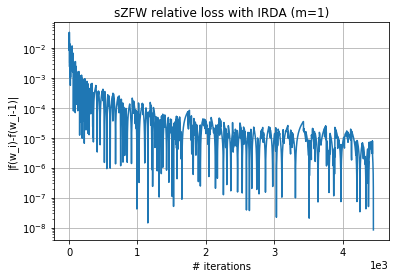

In [104]:
plt.plot(lossm1ad)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.title("sZFW relative loss with IRDA (m=1)")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/sZFW_IRDSAm1_relative_loss", dpi=400)

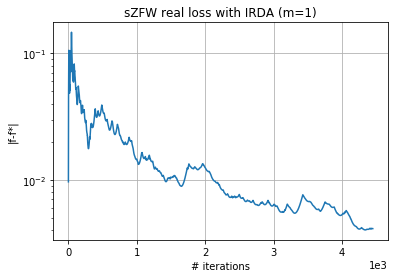

In [105]:
plt.plot(f_valuessm1ad - f_star)
plt.yscale("log")
plt.title("sZFW real loss with IRDA (m=1)")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/sZFW_IRDSAm1_real_loss", dpi=400)

In [106]:
%%time
fpred, f, w, mean, t, loss, f_valuess = stochasticZFW(F, d, w0, method = "IRDSA2", r=1, T=1000, eps=1e-8)

Loss evaluation at time 1:	0.0179398

Loss evaluation at time 2:	0.0074412

Loss evaluation at time 3:	0.0040208

Loss evaluation at time 4:	0.0049417

Loss evaluation at time 5:	0.0047129

Loss evaluation at time 6:	0.0134573

Loss evaluation at time 7:	0.0065697

Loss evaluation at time 8:	0.0057294

Loss evaluation at time 9:	0.0010003

Loss evaluation at time 10:	0.0033828

Loss evaluation at time 11:	0.0019378

Loss evaluation at time 12:	0.0054339

Loss evaluation at time 13:	0.0041329

Loss evaluation at time 14:	0.0032661

Loss evaluation at time 15:	0.0008378

Loss evaluation at time 16:	0.0020255

Loss evaluation at time 17:	0.0027135

Loss evaluation at time 18:	0.0007207

Loss evaluation at time 19:	0.0012784

Loss evaluation at time 20:	0.0002186

Loss evaluation at time 21:	0.0028544

Loss evaluation at time 22:	0.0008502

Loss evaluation at time 23:	0.0006759

Loss evaluation at time 24:	0.0002669

Loss evaluation at time 25:	0.0008200

Loss evaluation at time 26:	0.0045

Loss evaluation at time 214:	0.0000821

Loss evaluation at time 215:	0.0000250

Loss evaluation at time 216:	0.0000162

Loss evaluation at time 217:	0.0000327

Loss evaluation at time 218:	0.0000126

Loss evaluation at time 219:	0.0000827

Loss evaluation at time 220:	0.0000137

Loss evaluation at time 221:	0.0000808

Loss evaluation at time 222:	0.0000122

Loss evaluation at time 223:	0.0000273

Loss evaluation at time 224:	0.0000587

Loss evaluation at time 225:	0.0001414

Loss evaluation at time 226:	0.0000093

Loss evaluation at time 227:	0.0000133

Loss evaluation at time 228:	0.0000792

Loss evaluation at time 229:	0.0001426

Loss evaluation at time 230:	0.0002036

Loss evaluation at time 231:	0.0002622

Loss evaluation at time 232:	0.0000168

Loss evaluation at time 233:	0.0001386

Loss evaluation at time 234:	0.0000022

Loss evaluation at time 235:	0.0001238

Loss evaluation at time 236:	0.0000403

Loss evaluation at time 237:	0.0000734

Loss evaluation at time 238:	0.0000057



Loss evaluation at time 429:	0.0000510

Loss evaluation at time 430:	0.0000326

Loss evaluation at time 431:	0.0000229

Loss evaluation at time 432:	0.0000247

Loss evaluation at time 433:	0.0000025

Loss evaluation at time 434:	0.0000191

Loss evaluation at time 435:	0.0000166

Loss evaluation at time 436:	0.0000297

Loss evaluation at time 437:	0.0000034

Loss evaluation at time 438:	0.0000213

Loss evaluation at time 439:	0.0000049

Loss evaluation at time 440:	0.0000065

Loss evaluation at time 441:	0.0000485

Loss evaluation at time 442:	0.0000309

Loss evaluation at time 443:	0.0000090

Loss evaluation at time 444:	0.0000082

Loss evaluation at time 445:	0.0000148

Loss evaluation at time 446:	0.0000021

Loss evaluation at time 447:	0.0000186

Loss evaluation at time 448:	0.0000470

Loss evaluation at time 449:	0.0000268

Loss evaluation at time 450:	0.0000166

Loss evaluation at time 451:	0.0000030

Loss evaluation at time 452:	0.0000223

Loss evaluation at time 453:	0.0000517



Loss evaluation at time 636:	0.0000068

Loss evaluation at time 637:	0.0000174

Loss evaluation at time 638:	0.0000278

Loss evaluation at time 639:	0.0000241

Loss evaluation at time 640:	0.0000016

Loss evaluation at time 641:	0.0000131

Loss evaluation at time 642:	0.0000088

Loss evaluation at time 643:	0.0000024

Loss evaluation at time 644:	0.0000084

Loss evaluation at time 645:	0.0000154

Loss evaluation at time 646:	0.0000186

Loss evaluation at time 647:	0.0000202

Loss evaluation at time 648:	0.0000033

Loss evaluation at time 649:	0.0000102

Loss evaluation at time 650:	0.0000152

Loss evaluation at time 651:	0.0000050

Loss evaluation at time 652:	0.0000082

Loss evaluation at time 653:	0.0000184

Loss evaluation at time 654:	0.0000128

Loss evaluation at time 655:	0.0000022

Loss evaluation at time 656:	0.0000085

Loss evaluation at time 657:	0.0000157

Loss evaluation at time 658:	0.0000054

Loss evaluation at time 659:	0.0000080

Loss evaluation at time 660:	0.0000014



Loss evaluation at time 841:	0.0000111

Loss evaluation at time 842:	0.0000017

Loss evaluation at time 843:	0.0000073

Loss evaluation at time 844:	0.0000030

Loss evaluation at time 845:	0.0000014

Loss evaluation at time 846:	0.0000057

Loss evaluation at time 847:	0.0000099

Loss evaluation at time 848:	0.0000141

Loss evaluation at time 849:	0.0000196

Loss evaluation at time 850:	0.0000145

Loss evaluation at time 851:	0.0000095

Loss evaluation at time 852:	0.0000045

Loss evaluation at time 853:	0.0000005

Loss evaluation at time 854:	0.0000040

Loss evaluation at time 855:	0.0000093

Loss evaluation at time 856:	0.0000145

Loss evaluation at time 857:	0.0000196

Loss evaluation at time 858:	0.0000094

Loss evaluation at time 859:	0.0000034

Loss evaluation at time 860:	0.0000026

Loss evaluation at time 861:	0.0000085

Loss evaluation at time 862:	0.0000106

Loss evaluation at time 863:	0.0000052

Loss evaluation at time 864:	0.0000002

Loss evaluation at time 865:	0.0000055



In [107]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 0.009659341411376756

F(w_pred) = 0.00038424062090489336

F(w) = 0.00038994057577194333

w = [ 0.00000000e+00  3.83275507e-09  7.06759039e-03  2.97914942e-03
  0.00000000e+00  5.48147224e-03  1.13136615e-02  2.53118044e-09
  1.17865454e-02  6.52968900e-03  0.00000000e+00  8.27928987e-10
  1.38222470e-09  2.26590962e-04  3.47567031e-03  4.60037158e-09
  3.49734776e-03  0.00000000e+00  3.53478035e-03  1.68984528e-09
  0.00000000e+00  2.34076090e-03  0.00000000e+00  4.01248409e-10
  4.67683949e-09  4.73698212e-09  3.44693940e-09 -2.66980261e-03
 -1.64522723e-03 -3.36927224e-04  0.00000000e+00 -5.94646995e-03
 -1.66099210e-03  2.38063900e-09 -4.36823190e-03  0.00000000e+00
 -8.03892963e-04  4.43516570e-10  2.55777419e-09 -1.18791476e-02
  0.00000000e+00  5.32037512e-05 -1.56740121e-02  1.17129920e-09
  0.00000000e+00  0.00000000e+00 -3.29242919e-03  4.06789028e-09
  2.57387884e-09 -1.34967898e-03  0.00000000e+00  1.13001903e-09
  0.00000000e+00  2.94565431e-03  3.49975757e

In [108]:
loss_sad = np.load("../Data/results/loss_SZFW_lasso_AD.npy")
f_valuess = np.load("../Data/results/function_SZFW_lasso_AD.npy")

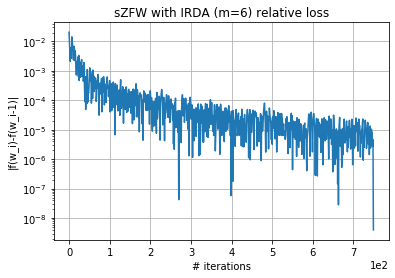

In [109]:
plt.plot(loss_sad)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.title("sZFW with IRDA (m=6) relative loss")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/sZFW_IRDSAm6_relative_loss", dpi=400)

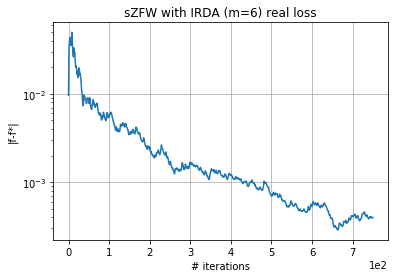

In [110]:
plt.plot(f_valuess - f_star)
plt.yscale("log")
plt.title("sZFW with IRDA (m=6) real loss")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/sZFW_IRDSAm6_real_loss", dpi=400)

## Zeroth order stochastic accelerated gradient method with Inexact updates on Artificial Dataset

In [ ]:
# setting parameters: UPDATE WITH THE FINAL ONES
B = 1 
L = 0.1
D = 10000

In [ ]:
%%time 

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 5, eps = 1e-8)


'''
with max iter = 100, m(101) = 1034

F(w_pred) = 0.01524209692890398

F(w) = 0.01502719283827

w = ***too long***

average w = ***too long***

T = 100
0.009651865274889974 0.01502719283827

--------------------------------------

with max iter = 1000, m(1001) = 100602

***Add .res***
'''

In [111]:
loss_i = np.load("../Data/results/loss_IZFW_AD_long.npy")
f_i = np.load("../Data/results/function_IZFW_AD_long.npy")
inner_i = np.load("../Data/results/inner_IZFW_AD_long.npy")

In [ ]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

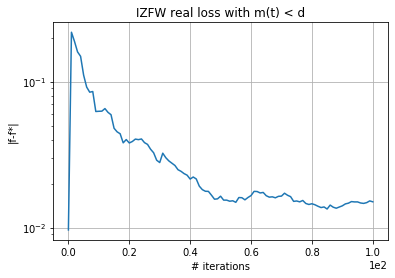

In [122]:
F_eval_i = np.abs(f_i - f_star)
plt.plot(F_eval_i)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW real loss with m(t) < d")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/IZFW_IRDSA_real_loss", dpi=400)

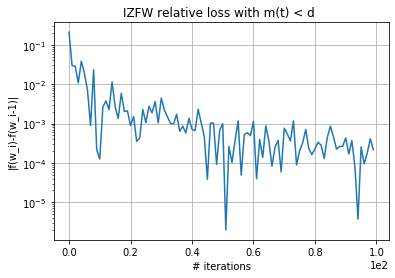

In [123]:
plt.plot(loss_i)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW relative loss with m(t) < d ")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/IZFW_IRDSA_relative_loss", dpi=400)

In [118]:
loss_i1000 = np.load("../Data/results/loss_IZFW_AD_long_1000.npy")
f_i1000 = np.load("../Data/results/function_IZFW_AD_long_1000.npy")
inner_i1000 = np.load("../Data/results/inner_IZFW_AD_long_1000.npy")

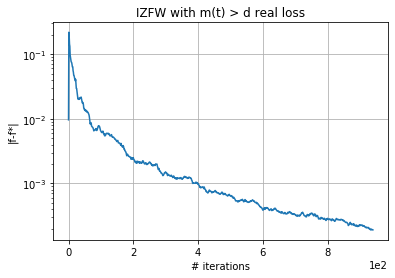

In [124]:
F_eval_i1000 = np.abs(f_i1000 - f_star)
plt.plot(F_eval_i1000)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) > d real loss")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/IZFW_IRDSA1000_real_loss", dpi=400)

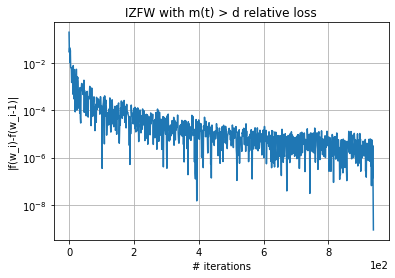

In [125]:
plt.plot(loss_i1000)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) > d relative loss")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/IZFW_IRDSA1000_relative_loss", dpi=400)

## Comparisons among all methods on Artificial Dataset

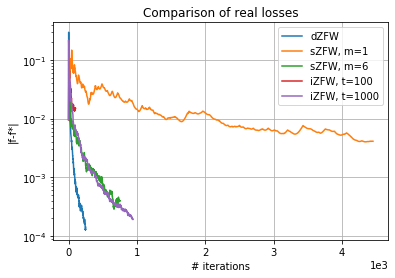

In [126]:
F_d = np.abs(f_valuesd - f_star)
F_sm1 = np.abs(f_valuessm1ad - f_star)
F_s = np.abs(f_valuess - f_star)
F_i = np.abs(f_i - f_star)
F_i1000 = np.abs(f_i1000 - f_star)
plt.plot(F_d)
plt.plot(F_sm1)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, t=100", "iZFW, t=1000"))
plt.xlabel('# iterations')
plt.ylabel('|f-f*|')
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_iteration", dpi=400)

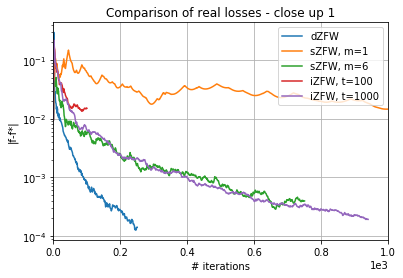

In [127]:
plt.plot(F_d)
plt.plot(F_sm1)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses - close up 1")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.xlim((0,1000))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, t=100", "iZFW, t=1000"), loc = "upper right")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_iteration_closeup1", dpi=400)

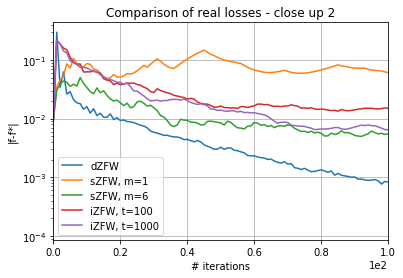

In [128]:
plt.plot(F_d)
plt.plot(F_sm1)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses - close up 2")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.xlim((0,100))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, t=100", "iZFW, t=1000"))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_iteration_closeup2", dpi=400)

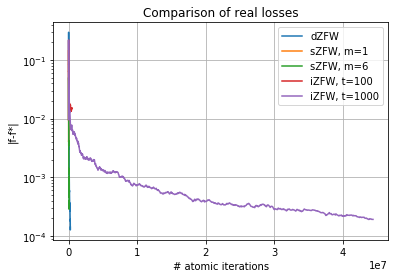

In [129]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, 251*d, d), F_d)
plt.plot(range(len(F_sm1)),F_sm1)
plt.plot(range(0, 750*100+1, 100), F_s)
plt.plot([m(t)+inner_i[t] for t in range(101)], F_i)
plt.plot([m(t)+inner_i1000[t] for t in range(len(inner_i1000))], f_i1000 - f_star)
plt.yscale("log")
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", 'iZFW, t=100','iZFW, t=1000'))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_atomic", dpi=400)

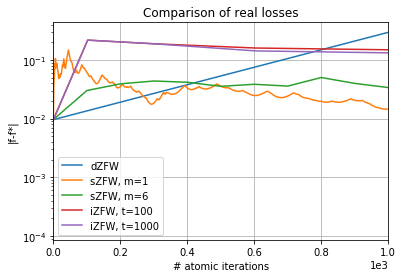

In [130]:
plt.plot(range(1, 251*d, d), F_d)
plt.plot(range(len(F_sm1)),F_sm1)
plt.plot(range(0, 750*100+1, 100), F_s)
plt.plot([m(t)+inner_i[t] for t in range(101)], F_i)
plt.plot([m(t)+inner_i1000[t] for t in range(len(inner_i1000))], f_i1000 - f_star)
plt.yscale("log")
plt.xlim((0, 1000))
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", 'iZFW, t=100','iZFW, t=1000'))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_atomic_closeup", dpi=400)